In [1]:
%matplotlib inline

In [14]:
import numpy as np
import pandas as pd
import pickle as pkl
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
from matplotlib import pyplot as plt
from datetime import timedelta, datetime
from joblib import delayed, Parallel
from copy import copy

from core import  do_simulation
from helpers import Params, T, get_T1_and_T2, R0, plot_total, DATE_FORMAT, total_to_csv, save_to_json, save_bundle

from const import STATE, COLORS, NUM_STATES,  STATES


In [3]:
p0_time = pkl.load(open('output/p0_time.pkl', 'rb'))
lockdown_time = T('23/01/2020')
days_before_ld  = (lockdown_time -  p0_time).days
params_before = pkl.load(
    open('output/params_before_lockdown.pkl', 'rb')
)

params_after = pkl.load(
    open('output/params_after_lockdown.pkl', 'rb')
)

bed_info = pkl.load(open('data/bed_info.pkl', 'rb'))

# infection_factor = 1.999881671966743
# additional_factor = 0.5  # 
infection_factor = 1.25
print(infection_factor)

1.25


In [12]:
total_days = 720
def one_run(days_before_lift):
    alpha_list = [
        (0, params_before.alpha),
        (days_before_ld, params_after.alpha),
        (days_before_lift, infection_factor * params_after.alpha)
    ]
    beta_list = [
        (0, params_before.beta),
        (days_before_ld, params_after.beta),
        (days_before_lift, infection_factor * params_after.beta)
    ]

    p = Params(
        alpha=alpha_list,
        beta=beta_list,
        stages=[days_before_ld, days_before_lift],
        initial_num_E=1,
        initial_num_I=0,
        initial_num_M=0
    )

    total, delta, increase, stats = do_simulation(total_days, bed_info, p, p0_time=p0_time)
    bundle = [total, delta, increase]
    return days_before_lift, bundle, stats

In [13]:
days_list = np.arange(150, 361, step=30)
rows = Parallel(n_jobs=-1)(delayed(one_run)(days) for days in days_list)

days = 150
[2.6510649337996512, 1.9825916135016703, 3.0463840013364347]


/home/cloud-user/code/covid-19/helpers.py:272: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['value'] = subdf[state].copy()
/home/cloud-user/code/covid-19/helpers.py:273: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del subdf[state]
/home/cloud-user/code/covid-19/helpers.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

['29/11/19' '21/04/20' '12/09/20' '03/02/21' '27/06/21' '18/11/21']
days = 180
[2.6510649337996512, 1.9800321707264243, 3.045048872162696]
['29/11/19' '21/04/20' '12/09/20' '03/02/21' '27/06/21' '18/11/21']
days = 210
[2.6510649337996512, 1.979282329945617, nan]
['29/11/19' '21/04/20' '12/09/20' '03/02/21' '27/06/21' '18/11/21']
days = 240
[2.6510649337996512, 1.979282329945617, nan]
['29/11/19' '21/04/20' '12/09/20' '03/02/21' '27/06/21' '18/11/21']
days = 270
[2.6510649337996512, 1.979282329945617, nan]
['29/11/19' '21/04/20' '12/09/20' '03/02/21' '27/06/21' '18/11/21']
days = 300
[2.6510649337996512, 1.979282329945617, nan]
['29/11/19' '21/04/20' '12/09/20' '03/02/21' '27/06/21' '18/11/21']
days = 330
[2.6510649337996512, 1.979282329945617, nan]
['29/11/19' '21/04/20' '12/09/20' '03/02/21' '27/06/21' '18/11/21']
days = 360
[2.6510649337996512, 1.979282329945617, nan]
['29/11/19' '21/04/20' '12/09/20' '03/02/21' '27/06/21' '18/11/21']


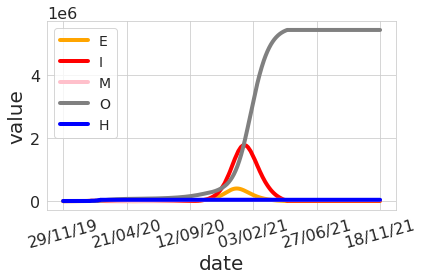

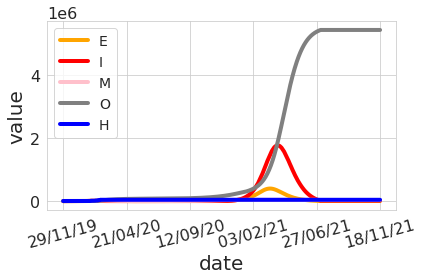

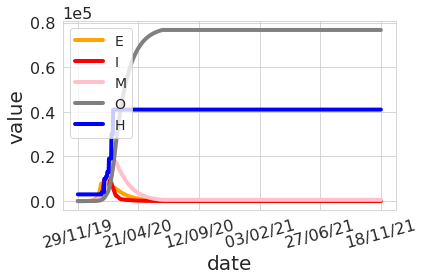

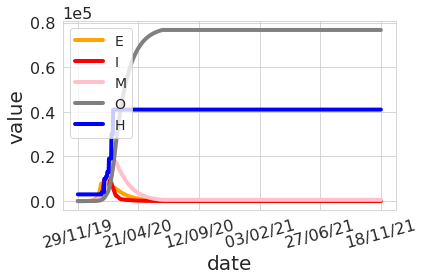

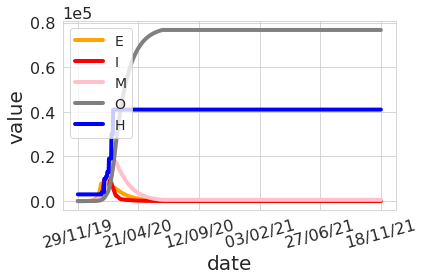

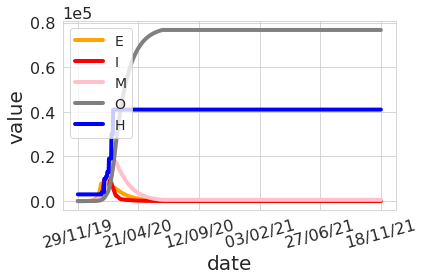

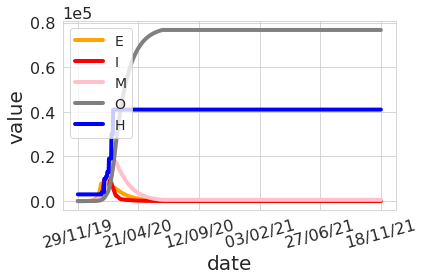

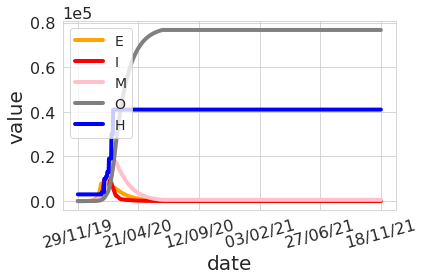

In [15]:
r0_rows = []
for days, bundle, stats in rows:    
    print('days =', days)
    r0_row = [t[-1] for t in stats['R0_by_stage'].values()]
    print(r0_row)
    r0_rows.append([days] + r0_row)
    fig, ax = plot_total(bundle[0], p0_time,  total_days)
    
    fig.savefig(f'figs/lift-lockdown/{days}.pdf')
    
    save_bundle(bundle, p0_time, total_days, f'output/tbl/lift-lockdown/{days}/')
    save_to_json(stats, f'output/tbl/lift-lockdown/{days}/stats.txt')

In [ ]:
df = pd.DataFrame(r0_rows, columns=['factor', 'before-ld', 'after-ld', 'after-ld-lift'])
df.to_csv('output/tbl/lift-lockdown/r0.csv', index=None)
df